In [8]:
%matplotlib inline
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

### Dados

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [3]:
X_train = train_images[:6000, :, :]
X_train_labels = train_labels[:6000, :]

X_valid = train_images[6000:7000, :, :]
X_valid_labels= train_labels[6000:7000, :]

X_test = test_images[:1000, :, :]
X_test_labels = test_labels[:1000, :]

In [4]:
print(X_train.shape)

(6000, 28, 28, 1)


In [5]:
print(X_train_labels.shape)

(6000, 10)


In [38]:
def plotFigureHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

### Questão 01

In [58]:
def calculateModel(funcl,opt):
    model = models.Sequential()
    model.add(layers.Conv2D(filters= 32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units= 64, activation='relu'))
    model.add(layers.Dense(units=10, activation='softmax'))
    
    model.compile(optimizer=opt, loss=funcl, metrics=['accuracy'])
    history = model.fit(X_train, X_train_labels, epochs=10, batch_size=64, 
                          validation_data=(X_valid, X_valid_labels))
    
    model_loss, model_acc = model.evaluate(X_test, X_test_labels)
    print('Loss: {} | Accuracy: {}'.format(model_loss, model_acc))
    
    plotFigureHistory(history)

#### Loss: mean_squared_error | Optimizer: SGD

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 3s 549us/step - loss: 0.0901 - acc: 0.1040 - val_loss: 0.0900 - val_acc: 0.1020
Epoch 2/10
6000/6000 [==============================] - 3s 529us/step - loss: 0.0901 - acc: 0.1065 - val_loss: 0.0900 - val_acc: 0.1060
Epoch 3/10
6000/6000 [==============================] - 3s 478us/step - loss: 0.0900 - acc: 0.1067 - val_loss: 0.0900 - val_acc: 0.1060
Epoch 4/10
6000/6000 [==============================] - 3s 538us/step - loss: 0.0900 - acc: 0.1090 - val_loss: 0.0900 - val_acc: 0.1110
Epoch 5/10
6000/6000 [==============================] - 3s 496us/step - loss: 0.0900 - acc: 0.1103 - val_loss: 0.0899 - val_acc: 0.1140
Epoch 6/10
6000/6000 [==============================] - 3s 520us/step - loss: 0.0900 - acc: 0.1120 - val_loss: 0.0899 - val_acc: 0.1160
Epoch 7/10
6000/6000 [==============================] - 3s 550us/step - loss: 0.0900 - acc: 0.1133 - val_loss: 0.0899 - val_acc: 0.1150


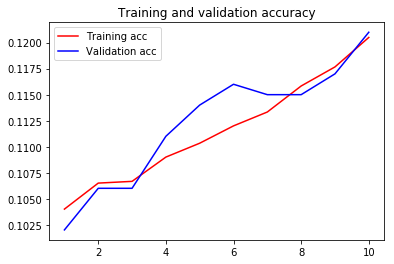

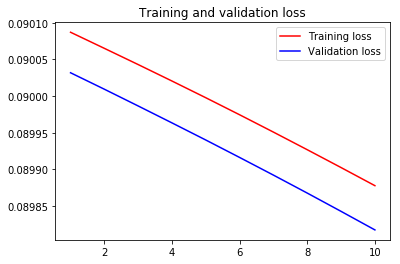

In [59]:
calculateModel(funcl=losses.mean_squared_error,opt=optimizers.SGD())

#### Loss: mean_squared_error | Optimizer: Adamax

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 591us/step - loss: 0.0382 - acc: 0.7248 - val_loss: 0.0162 - val_acc: 0.8920
Epoch 2/10
6000/6000 [==============================] - 3s 476us/step - loss: 0.0114 - acc: 0.9253 - val_loss: 0.0091 - val_acc: 0.9400
Epoch 3/10
6000/6000 [==============================] - 3s 479us/step - loss: 0.0081 - acc: 0.9498 - val_loss: 0.0064 - val_acc: 0.9600
Epoch 4/10
6000/6000 [==============================] - 3s 510us/step - loss: 0.0058 - acc: 0.9653 - val_loss: 0.0067 - val_acc: 0.9600
Epoch 5/10
6000/6000 [==============================] - 3s 504us/step - loss: 0.0050 - acc: 0.9677 - val_loss: 0.0063 - val_acc: 0.9600
Epoch 6/10
6000/6000 [==============================] - 3s 528us/step - loss: 0.0040 - acc: 0.9745 - val_loss: 0.0065 - val_acc: 0.9590
Epoch 7/10
6000/6000 [==============================] - 3s 494us/step - loss: 0.0032 - acc: 0.9808 - val_loss: 0.0049 - val_acc: 0.9690


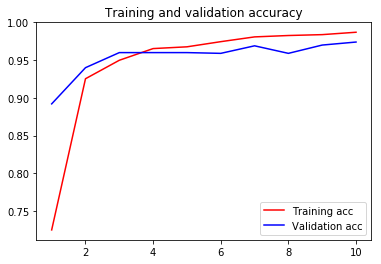

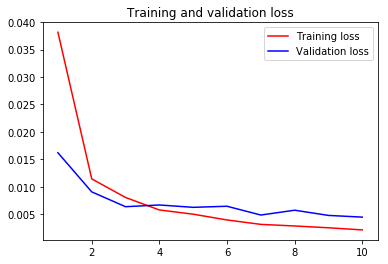

In [64]:
calculateModel(funcl=losses.mean_squared_error,opt=optimizers.Adamax())

#### Loss: mean_squared_error | Optimizer: Nadam

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 625us/step - loss: 0.0587 - acc: 0.6127 - val_loss: 0.0378 - val_acc: 0.7920
Epoch 2/10
6000/6000 [==============================] - 3s 535us/step - loss: 0.0177 - acc: 0.8943 - val_loss: 0.0097 - val_acc: 0.9410
Epoch 3/10
6000/6000 [==============================] - 3s 484us/step - loss: 0.0089 - acc: 0.9432 - val_loss: 0.0062 - val_acc: 0.9600
Epoch 4/10
6000/6000 [==============================] - 3s 539us/step - loss: 0.0061 - acc: 0.9617 - val_loss: 0.0052 - val_acc: 0.9680
Epoch 5/10
6000/6000 [==============================] - 3s 476us/step - loss: 0.0050 - acc: 0.9683 - val_loss: 0.0060 - val_acc: 0.9610
Epoch 6/10
6000/6000 [==============================] - 3s 576us/step - loss: 0.0039 - acc: 0.9762 - val_loss: 0.0050 - val_acc: 0.9690
Epoch 7/10
6000/6000 [==============================] - 3s 486us/step - loss: 0.0040 - acc: 0.9760 - val_loss: 0.0062 - val_acc: 0.9600


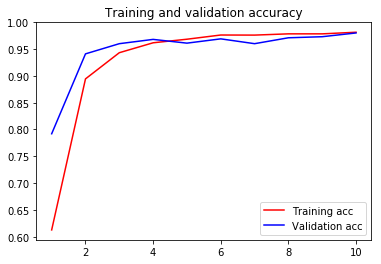

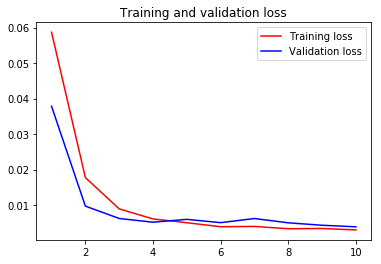

In [63]:
calculateModel(funcl=losses.mean_squared_error,opt=optimizers.Nadam())

#### Loss: poisson | Optimizer: SGD

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 634us/step - loss: 0.3299 - acc: 0.1047 - val_loss: 0.3296 - val_acc: 0.1100
Epoch 2/10
6000/6000 [==============================] - 3s 491us/step - loss: 0.3294 - acc: 0.1125 - val_loss: 0.3291 - val_acc: 0.1160
Epoch 3/10
6000/6000 [==============================] - 3s 551us/step - loss: 0.3289 - acc: 0.1262 - val_loss: 0.3286 - val_acc: 0.1300
Epoch 4/10
6000/6000 [==============================] - 3s 496us/step - loss: 0.3284 - acc: 0.1483 - val_loss: 0.3281 - val_acc: 0.1640
Epoch 5/10
6000/6000 [==============================] - 3s 504us/step - loss: 0.3279 - acc: 0.1710 - val_loss: 0.3276 - val_acc: 0.1870
Epoch 6/10
6000/6000 [==============================] - 3s 529us/step - loss: 0.3275 - acc: 0.1865 - val_loss: 0.3271 - val_acc: 0.2060
Epoch 7/10
6000/6000 [==============================] - 3s 568us/step - loss: 0.3270 - acc: 0.1992 - val_loss: 0.3266 - val_acc: 0.2120


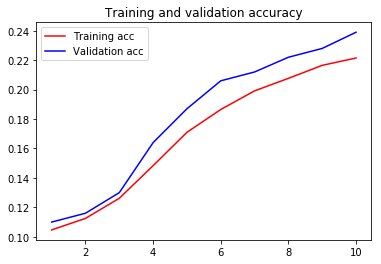

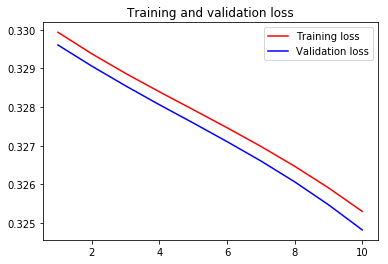

In [65]:
calculateModel(funcl=losses.poisson,opt=optimizers.SGD())

#### Loss: poisson | Optimizer: Adamax

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 637us/step - loss: 0.1898 - acc: 0.7502 - val_loss: 0.1331 - val_acc: 0.9040
Epoch 2/10
6000/6000 [==============================] - 3s 514us/step - loss: 0.1274 - acc: 0.9177 - val_loss: 0.1219 - val_acc: 0.9420
Epoch 3/10
6000/6000 [==============================] - 3s 491us/step - loss: 0.1186 - acc: 0.9430 - val_loss: 0.1166 - val_acc: 0.9550
Epoch 4/10
6000/6000 [==============================] - 3s 551us/step - loss: 0.1140 - acc: 0.9602 - val_loss: 0.1150 - val_acc: 0.9590
Epoch 5/10
6000/6000 [==============================] - 3s 544us/step - loss: 0.1113 - acc: 0.9680 - val_loss: 0.1146 - val_acc: 0.9590
Epoch 6/10
6000/6000 [==============================] - 3s 539us/step - loss: 0.1092 - acc: 0.9708 - val_loss: 0.1144 - val_acc: 0.9570
Epoch 7/10
6000/6000 [==============================] - 3s 529us/step - loss: 0.1084 - acc: 0.9760 - val_loss: 0.1110 - val_acc: 0.9720


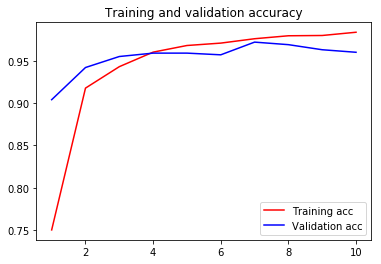

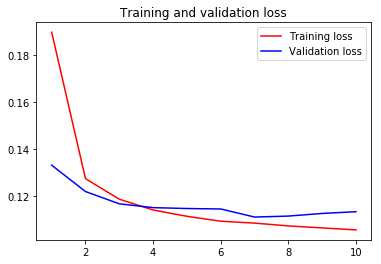

In [66]:
calculateModel(funcl=losses.poisson,opt=optimizers.Adamax())

#### Loss: poisson | Optimizer: Nadam

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 654us/step - loss: 0.1629 - acc: 0.7995 - val_loss: 0.1178 - val_acc: 0.9510
Epoch 2/10
6000/6000 [==============================] - 3s 531us/step - loss: 0.1148 - acc: 0.9573 - val_loss: 0.1131 - val_acc: 0.9620
Epoch 3/10
6000/6000 [==============================] - 3s 559us/step - loss: 0.1089 - acc: 0.9735 - val_loss: 0.1234 - val_acc: 0.9330
Epoch 4/10
6000/6000 [==============================] - 3s 530us/step - loss: 0.1066 - acc: 0.9807 - val_loss: 0.1094 - val_acc: 0.9770
Epoch 5/10
6000/6000 [==============================] - 3s 583us/step - loss: 0.1042 - acc: 0.9868 - val_loss: 0.1121 - val_acc: 0.9750
Epoch 6/10
6000/6000 [==============================] - 3s 528us/step - loss: 0.1035 - acc: 0.9877 - val_loss: 0.1090 - val_acc: 0.9760
Epoch 7/10
6000/6000 [==============================] - 4s 586us/step - loss: 0.1030 - acc: 0.9905 - val_loss: 0.1075 - val_acc: 0.9780


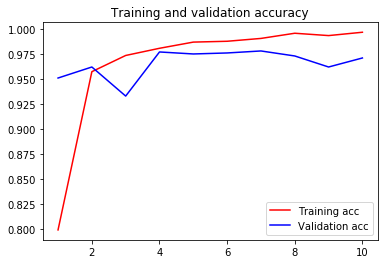

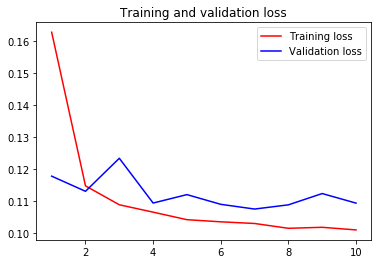

In [67]:
calculateModel(funcl=losses.poisson,opt=optimizers.Nadam())

#### Loss: categorical_crossentropy | Optimizer: SGD

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 642us/step - loss: 2.2694 - acc: 0.1755 - val_loss: 2.2286 - val_acc: 0.2770
Epoch 2/10
6000/6000 [==============================] - 3s 472us/step - loss: 2.1408 - acc: 0.3887 - val_loss: 1.9894 - val_acc: 0.5780
Epoch 3/10
6000/6000 [==============================] - 3s 473us/step - loss: 1.5489 - acc: 0.6588 - val_loss: 0.9659 - val_acc: 0.7690
Epoch 4/10
6000/6000 [==============================] - 3s 535us/step - loss: 0.7626 - acc: 0.7813 - val_loss: 0.5943 - val_acc: 0.8110
Epoch 5/10
6000/6000 [==============================] - 3s 500us/step - loss: 0.5211 - acc: 0.8410 - val_loss: 0.4132 - val_acc: 0.8800
Epoch 6/10
6000/6000 [==============================] - 3s 527us/step - loss: 0.4003 - acc: 0.8832 - val_loss: 0.3103 - val_acc: 0.9120
Epoch 7/10
6000/6000 [==============================] - 3s 504us/step - loss: 0.3452 - acc: 0.8902 - val_loss: 0.3591 - val_acc: 0.8860


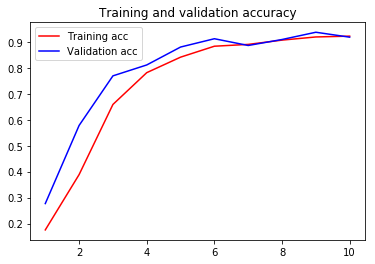

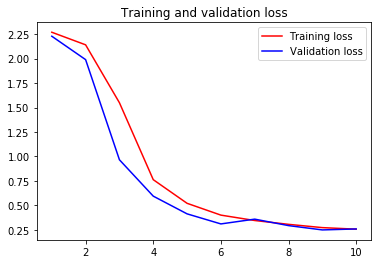

In [68]:
calculateModel(funcl=losses.categorical_crossentropy,opt=optimizers.SGD())

#### Loss: categorical_crossentropy | Optimizer: Adamax

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 737us/step - loss: 0.8395 - acc: 0.7397 - val_loss: 0.2578 - val_acc: 0.9250
Epoch 2/10
6000/6000 [==============================] - 3s 525us/step - loss: 0.2563 - acc: 0.9253 - val_loss: 0.2591 - val_acc: 0.9160
Epoch 3/10
6000/6000 [==============================] - 3s 519us/step - loss: 0.1822 - acc: 0.9480 - val_loss: 0.1634 - val_acc: 0.9520
Epoch 4/10
6000/6000 [==============================] - 3s 550us/step - loss: 0.1407 - acc: 0.9590 - val_loss: 0.1240 - val_acc: 0.9630
Epoch 5/10
6000/6000 [==============================] - 3s 537us/step - loss: 0.1076 - acc: 0.9688 - val_loss: 0.1215 - val_acc: 0.9630
Epoch 6/10
6000/6000 [==============================] - 3s 555us/step - loss: 0.0957 - acc: 0.9713 - val_loss: 0.1206 - val_acc: 0.9650
Epoch 7/10
6000/6000 [==============================] - 3s 513us/step - loss: 0.0840 - acc: 0.9755 - val_loss: 0.1017 - val_acc: 0.9670


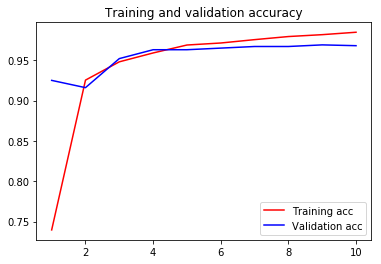

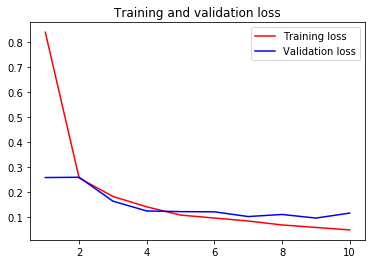

In [69]:
calculateModel(funcl=losses.categorical_crossentropy,opt=optimizers.Adamax())

#### Loss: categorical_crossentropy | Optimizer: Nadam

In [ ]:
calculateModel(funcl=losses.categorical_crossentropy,opt=optimizers.Nadam())

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 725us/step - loss: 0.7295 - acc: 0.7785 - val_loss: 0.2422 - val_acc: 0.9260
Epoch 2/10
6000/6000 [==============================] - 3s 544us/step - loss: 0.1808 - acc: 0.9462 - val_loss: 0.1431 - val_acc: 0.9640
Epoch 3/10
3520/6000 [================>.............] - ETA: 1s - loss: 0.1185 - acc: 0.9634